In [1]:
import sys
sys.path.insert(0, './yolov5')

In [2]:
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from yolov5.utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from yolov5.utils.plots import Annotator, colors, save_one_box
from yolov5.utils.augmentations import letterbox
from yolov5.utils.torch_utils import select_device, time_sync

/opt/conda/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import cv2
import base64
import copy
from glob import glob
import os
import os.path as osp
import logging
import argparse
import torch
import time
from tqdm import tqdm
import copy
from easydict import EasyDict as edict
import datetime

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
opt_car = edict({
    "yolo_model" : "./weights/car_best.pt",
    "output" : "inference/output",
    "conf_thres" : 0.2,
    "iou_thres" : 0.3,
    "device" : "cuda:1",
    "save_txt" : True,
    "save_vid" : False,
    "show_vid" : False,
    "classes" : [0],
    "agnostic_nms" : True,
    "augment" : False,
    "evaluate" : True,
    "half" : True,
    "visualize" : True,
    "max_det" : 1000,
    "dnn" : True,
    "project" : "runs/track",
    "exist_ok" : True
})

In [6]:
device = select_device(opt_car.device)
car_model = DetectMultiBackend(opt_car.yolo_model, device=device, dnn=opt_car.dnn, fp16=False)
stride, names, pt = car_model.stride, car_model.names, car_model.pt
imgsz = check_img_size(640, s=stride)  # check image size
car_model = car_model.eval()

YOLOv5 🚀 v6.1-32-gc13d4ce torch 1.10.1+cu113 CUDA:1 (NVIDIA RTX A6000, 48685MiB)

Fusing layers... 
Model Summary: 574 layers, 139970872 parameters, 0 gradients, 208.1 GFLOPs


In [7]:
opt_cycle = edict({
    "yolo_model" : "./weights/cycle_best.pt",
    "output" : "inference/output",
    "conf_thres" : 0.5,
    "iou_thres" : 0.1,
    "device" : "cuda:1",
    "save_txt" : True,
    "save_vid" : False,
    "show_vid" : False,
    "classes" : [0],
    "agnostic_nms" : True,
    "augment" : False,
    "evaluate" : True,
    "half" : True,
    "visualize" : True,
    "max_det" : 1000,
    "dnn" : True,
    "project" : "runs/track",
    "exist_ok" : True
})

In [8]:
device = select_device(opt_cycle.device)
cycle_model = DetectMultiBackend(opt_cycle.yolo_model, device=device, dnn=opt_cycle.dnn, fp16=False)
stride, names, pt = cycle_model.stride, cycle_model.names, cycle_model.pt
imgsz = check_img_size(640, s=stride)  # check image size
cycle_model = cycle_model.eval()

YOLOv5 🚀 v6.1-32-gc13d4ce torch 1.10.1+cu113 CUDA:1 (NVIDIA RTX A6000, 48685MiB)

Fusing layers... 
Model Summary: 574 layers, 139970872 parameters, 0 gradients, 208.1 GFLOPs


In [9]:
imgv1_list = sorted(glob("/data/IEEE_BigData/test/test_v1/*.jpg"))
imgv2_list = sorted(glob("/data/IEEE_BigData/test/test_v2/*.jpg"))

In [10]:
imgv1_list[0].split("/")[-1].replace("jpg", "txt")

'0.txt'

In [11]:
dic = {"0" : "car_back",
       "1" : "car_side",
       "2" : "car_front",
       "3" : "truck_back",
       "4" : "truck_side",
       "5" : "truck_front",
       "6" : "motorcycle_back",
       "7" : "motorcycle_side",
       "8" : "motorcycle_front",
       "9" : "bicycle_back",
       "10" : "bicycle_side",
       "11" : "bicycle_front"}

# v1

In [12]:
txt = open("./detection_submission/testv1_submission_0926_01.txt" ,"w")

In [13]:
for i in tqdm(range(len(imgv1_list))):
    img = cv2.imread(imgv1_list[i])
    shape = img.shape
    img = letterbox(img, imgsz, stride, auto=pt)[0]
    img = img.transpose((2, 0, 1))[::-1]
    img = np.ascontiguousarray(img)
    
    img = torch.from_numpy(img)
    img = img.to(device)
    img = img.float()
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    # Car
    pred = car_model(img, augment=True, visualize=False)
    det = non_max_suppression(pred, opt_car.conf_thres, opt_car.iou_thres, opt_car.classes, opt_car.agnostic_nms, max_det=opt_car.max_det)[0]
    
    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], shape)
    
    # Print results
    for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  # detections per class

    xyxys = det[:, 0:4]
    confs = det[:, 4]
    clss = det[:, 5]
    
    f_name = imgv1_list[i].split("/")[-1].replace("jpg", "txt")
    
    sentence = f"{f_name}"
    
    for j in range(len(xyxys)):
        sentence = sentence +  f" {dic[str(int(clss[j]))]} {confs[j]} {xyxys[j][0]} {xyxys[j][1]} {xyxys[j][2]} {xyxys[j][3]}"
        
    # Cycle
    pred = cycle_model(img, augment=True, visualize=False)
    det = non_max_suppression(pred, opt_cycle.conf_thres, opt_cycle.iou_thres, opt_cycle.classes, opt_cycle.agnostic_nms, max_det=opt_cycle.max_det)[0]
    
    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], shape)
    
    # Print results
    for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  # detections per class

    xyxys = det[:, 0:4]
    confs = det[:, 4]
    clss = det[:, 5]
    
    f_name = imgv1_list[i].split("/")[-1].replace("jpg", "txt")
    
    for j in range(len(xyxys)):
        sentence = sentence +  f" {dic[str(int(clss[j]))]} {confs[j]} {xyxys[j][0]} {xyxys[j][1]} {xyxys[j][2]} {xyxys[j][3]}"
        
    sentence = sentence + "\n"
    
    txt.write(sentence)
    
txt.close()

100%|██████████| 1500/1500 [03:16<00:00,  7.62it/s]


# v2

In [14]:
txt = open("./detection_submission/testv2_submission_0926_01.txt" ,"w")

In [15]:
for i in tqdm(range(len(imgv2_list))):
    img = cv2.imread(imgv2_list[i])
    shape = img.shape
    img = letterbox(img, imgsz, stride, auto=pt)[0]
    img = img.transpose((2, 0, 1))[::-1]
    img = np.ascontiguousarray(img)
    
    img = torch.from_numpy(img)
    img = img.to(device)
    img = img.float()
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    # Car
    pred = car_model(img, augment=True, visualize=False)
    det = non_max_suppression(pred, opt_car.conf_thres, opt_car.iou_thres, opt_car.classes, opt_car.agnostic_nms, max_det=opt_car.max_det)[0]
    
    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], shape)
    
    # Print results
    for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  # detections per class

    xyxys = det[:, 0:4]
    confs = det[:, 4]
    clss = det[:, 5]
    
    f_name = imgv2_list[i].split("/")[-1].replace("jpg", "txt")
    
    sentence = f"{f_name}"
    
    for j in range(len(xyxys)):
        sentence = sentence +  f" {dic[str(int(clss[j]))]} {confs[j]} {xyxys[j][0]} {xyxys[j][1]} {xyxys[j][2]} {xyxys[j][3]}"
        
    # Cycle
    pred = cycle_model(img, augment=True, visualize=False)
    det = non_max_suppression(pred, opt_cycle.conf_thres, opt_cycle.iou_thres, opt_cycle.classes, opt_cycle.agnostic_nms, max_det=opt_cycle.max_det)[0]
    
    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], shape)
    
    # Print results
    for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  # detections per class

    xyxys = det[:, 0:4]
    confs = det[:, 4]
    clss = det[:, 5]
    
    f_name = imgv2_list[i].split("/")[-1].replace("jpg", "txt")
    
    for j in range(len(xyxys)):
        sentence = sentence +  f" {dic[str(int(clss[j]))]} {confs[j]} {xyxys[j][0]} {xyxys[j][1]} {xyxys[j][2]} {xyxys[j][3]}"
        
    sentence = sentence + "\n"
    
    txt.write(sentence)
    
txt.close()

100%|██████████| 1500/1500 [03:06<00:00,  8.05it/s]


# Visualization

In [16]:
import matplotlib.patches as patches

In [17]:
a = sentence.split(" ")

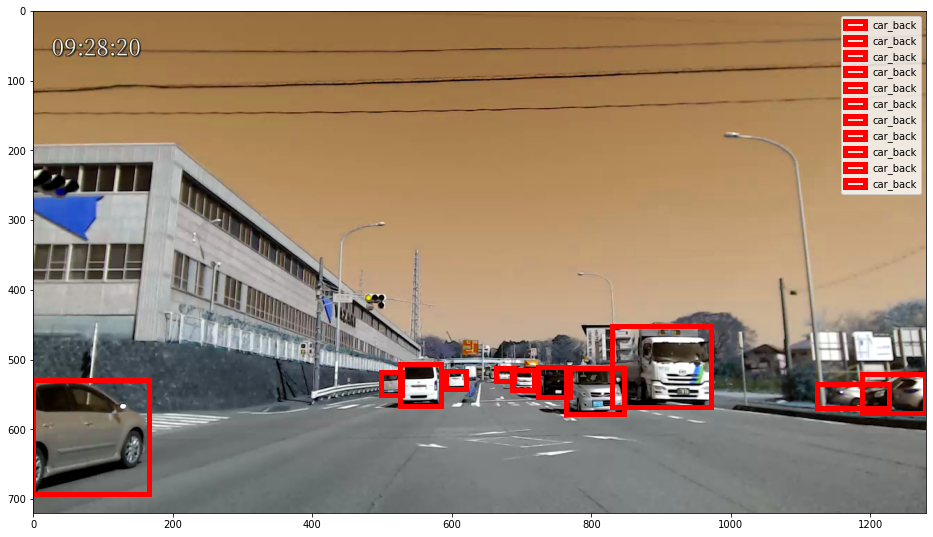

In [18]:
img = cv2.imread(imgv2_list[-1])

plt.rcParams['figure.figsize'] = (16, 16)

fig, ax = plt.subplots()

for i in range((len(a) -1)// 6):
    ax.add_patch(
       patches.Rectangle(
          (int(float(a[3 + 6 * i])), int(float(a[4 + 6 * i]))),   # (x, y)
          int(float(a[5 + 6 * i])-float(a[3 + 6 * i])), int(float(a[6 + 6 * i])-float(a[4 + 6 * i])),   # width, height
          edgecolor = 'red',
          facecolor = 'lightgray',
          linewidth=5,
          fill=False,
          label=a[1 + 6 * i]
       ))
plt.legend(loc='upper right')
ax.imshow(img)